# Load Spark

In [0]:
# Install latest version of spark. If error, check the latest and replace "spark-2.4.4"
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
import findspark
findspark.init()

In [0]:
#The entry point to using Spark SQL is an object called SparkSession. 
#It initiates a Spark Application which all the code for that Session will run on.
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

In [0]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Q2. Binary classification with Spark MLlib
## (1). Data loading
Read the csv file into a Dataframe. You could set "inferschema" to true and rename the columns with the following information: "age", "workclass", "fnlwgt","education", "education_num", "marital_status", "occupation", "relationship","race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country","income".

In [0]:
DATA_PATH = "/content/gdrive/My Drive/BigData/q1/adult_data.csv"

In [74]:
data = spark.read.csv(DATA_PATH,inferSchema=True, header=False)
print(data.count(),len(data.columns))
data.show(5)

32561 15
+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-------+------+----+----+--------------+------+
|_c0|              _c1|     _c2|       _c3| _c4|                _c5|               _c6|           _c7|   _c8|    _c9|  _c10|_c11|_c12|          _c13|  _c14|
+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-------+------+----+----+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|2174.0| 0.0|40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|   0.0| 0.0|13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad| 9.0|           Divorced| Handlers-cleaners| Not-in-family| White|   Male|   0.0| 0.0|40.0| United-States| <=50K|
| 53|          Private|234721.0|      11th| 7.0| 

In [75]:
col_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
             "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
             "hours_per_week", "native_country", "income"]
print(len(col_names))
data = data.toDF(*col_names)
data.show(5)

15
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad|    

In [76]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



## (2). Data preprocessing
Convert the categorical variables into numeric variables with ML Pipelines and Feature Transformers . You will probably need OneHotEncoderEstimator,
StringIndexer, and VectorAssembler. Split your data into training set and test set with ratio of 70% and 30% and set the seed to 100.

Reference:
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

In [77]:
train, test = data.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 22838
Test Dataset Count: 9723


In [0]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital_status','occupation','relationship',
                     'race','sex','native_country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [79]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)
train = pipelineModel.transform(train)

selectedCols = ['label', 'features'] + col_names
train = train.select(selectedCols)
train.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



## (3). Modelling
Train a logistic regression model with train set. Learn more about models provide in Spark MLlib here . After training, plot ROC curve and Precision-Recall curve of your training process.

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

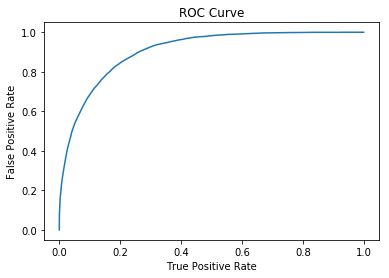

Training set areaUnderROC: 0.9056654937412549


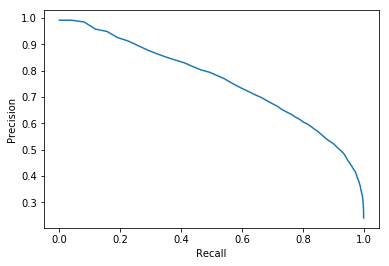

In [81]:
import matplotlib.pyplot as plt
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## (4). Evaluation
Apply your trained model on the test set. Provide the value of area under ROC, accuracy, and confusion matrix. You should expect the accuracy to be around 85%.

In [82]:
test = pipelineModel.transform(test)
test = test.select(selectedCols)

predictions = lrModel.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9027382028865563


In [84]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test accuracy: ", accuracy)

Test accuracy:  0.8484006993726216


In [87]:
from sklearn.metrics import confusion_matrix
y_true = test.select('label').collect()
y_pred = predictions.select('prediction').collect()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[6860,  530],
       [ 944, 1389]])